# Wage Prediction with Neural Networks
## Using All Variables (Including Irrelevant Ones)

*This notebook demonstrates:*
- *4-layer neural network implementation in PyTorch*
- *Batch training implementation with DataLoader*
- *Handling of both relevant and irrelevant variables*
- *Overfitting detection through validation metrics*

## 1. Data Preparation with Batch Support

In [6]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader  # For batch training
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

# Load and inspect the dataset
data = pd.read_csv('./DATA/wage_data.csv')
print("First 5 rows of the dataset:")
print(data.head())

# Transfer categorical features to dummy
# One-hot encode three categorical columns with drop_first=True
cat_cols = ['clothing_color', 'birth_month', 'favorite_number']
# Fit-time: create dummies from data
data = pd.get_dummies(data, columns=cat_cols, drop_first=True)
print(data.head())
print("The categorical features were transformed to dummy variables.")

# Prepare features and target variable
X = data.drop(columns=['log_wage'])
y = data['log_wage']

# Split data into training (60%), validation (20%), and test (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

for df in [X_train, X_val, X_test, y_train, y_val, y_test]:
    df.reset_index(drop=True, inplace=True)
print("Data split successfully")

# Standardize features using training set statistics
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert numpy arrays to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(y_val)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

# Create DataLoader objects for batch training
batch_size = 32  # Define batch size for training
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Print dataset information
print(f"\nTraining samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")
print(f"Number of features: {X_train.shape[1]}")
print(f"Batch size: {batch_size}, Batches per epoch: {len(train_loader)}")

First 5 rows of the dataset:
        educ      exper   exper_sq   ability  female  union     height  \
0  14.993428  16.996777  288.89040 -0.675178     1.0    1.0  178.08919   
1  13.723472  14.623168  213.83704 -0.144519     1.0    0.0  164.15544   
2  15.295377  10.298152  106.05193 -0.792420     0.0    1.0  162.50642   
3  17.046060   6.765316   45.76950 -0.307962     1.0    0.0  167.78464   
4  13.531693  13.491117  182.01022 -1.893615     0.0    0.0  158.23038   

   commute_km  birth_month  favorite_number clothing_color  log_wage  
0         1.7          1.0              8.0           blue  4.978068  
1         2.0          4.0              4.0           gray  4.968439  
2         4.5         10.0              8.0          white  5.270698  
3         5.7          7.0              9.0           blue  4.455431  
4         9.8          2.0              7.0           gray  4.859989  
        educ      exper   exper_sq   ability  female  union     height  \
0  14.993428  16.996777  2

## 2. Neural Network Architecture Definition

In [7]:
# Define the neural network architecture
class WageNN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        # Define network layers
        self.network = nn.Sequential(
            nn.Linear(input_size, 256),  # Input layer
            nn.ReLU(),                  # Activation function
            nn.Dropout(0.3),            # Dropout for regularization
            nn.Linear(256, 128),        # Hidden layer 1
            nn.ReLU(),                  # Activation
            nn.Linear(128, 64),         # Hidden layer 2
            nn.ReLU(),                  # Activation
            nn.Linear(64, 1)            # Output layer
        )
        
    def forward(self, x):
        # Forward pass through the network
        return self.network(x)

# Initialize model, loss function, and optimizer
model = WageNN(input_size=X_train.shape[1])
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Adam optimizer with L2 regularization

# Calculate and print total number of trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("\nModel Architecture:")
print(model)
print(f"\nTotal trainable parameters: {total_params:,}")


Model Architecture:
WageNN(
  (network): Sequential(
    (0): Linear(in_features=31, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=64, bias=True)
    (6): ReLU()
    (7): Linear(in_features=64, out_features=1, bias=True)
  )
)

Total trainable parameters: 49,409


## 3. Training Process with Batch Support

In [8]:
# Initialize lists to track losses
train_losses = []
val_losses = []
epochs = 300
best_val_loss = float('inf')  # Initialize best validation loss

# Training loop
for epoch in range(epochs):
    # Training phase
    model.train()  # Set model to training mode
    running_train_loss = 0.0
    
    # Iterate over batches
    for X_batch, y_batch in train_loader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Accumulate loss (weighted by batch size)
        running_train_loss += loss.item() * len(X_batch)
    
    # Calculate average training loss for the epoch
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # Validation phase
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    
    with torch.no_grad():  # Disable gradient calculation
        for X_batch, y_batch in val_loader:
            # Forward pass
            val_outputs = model(X_batch)
            val_loss = criterion(val_outputs, y_batch)
            
            # Accumulate validation loss
            running_val_loss += val_loss.item() * len(X_batch)
    
    # Calculate average validation loss
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    # Check for best model
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), 'best_model.pth')  # Save best model
    
    # Print progress every 30 epochs
    if (epoch+1) % 30 == 0:
        print(f'Epoch {epoch+1:3d} | Train MSE: {epoch_train_loss:.5f} | Val MSE: {epoch_val_loss:.5f}')

# Load the best model weights
model.load_state_dict(torch.load('best_model.pth'))
print("\nTraining completed. Best model loaded.")

/Users/qingfengliu/anaconda3/envs/ML_Introduction/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/qingfengliu/anaconda3/envs/ML_Introduction/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/qingfengliu/anaconda3/envs/ML_Introduction/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will like

Epoch  30 | Train MSE: 0.59624 | Val MSE: 0.47354
Epoch  60 | Train MSE: 0.58126 | Val MSE: 0.42196
Epoch  90 | Train MSE: 0.58125 | Val MSE: 0.43569
Epoch 120 | Train MSE: 0.54047 | Val MSE: 0.41680
Epoch 150 | Train MSE: 0.52823 | Val MSE: 0.41003
Epoch 180 | Train MSE: 0.50319 | Val MSE: 0.43040
Epoch 210 | Train MSE: 0.50980 | Val MSE: 0.56222
Epoch 240 | Train MSE: 0.50344 | Val MSE: 0.41963
Epoch 270 | Train MSE: 0.48987 | Val MSE: 0.42197
Epoch 300 | Train MSE: 0.48536 | Val MSE: 0.45228

Training completed. Best model loaded.


## 4. Model Evaluation with Batch Support

In [ ]:
# Function to evaluate model performance in batches
def evaluate_model(model, X, y, batch_size=32):
    """
    Evaluates model on given data in batches
    Args:
        model: The neural network model
        X: Input features
        y: Target values
        batch_size: Number of samples per batch
    Returns:
        Average loss over all batches
    """
    dataset = TensorDataset(X, y)
    loader = DataLoader(dataset, batch_size=batch_size)
    total_loss = 0.0
    model.eval()
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item() * len(X_batch)
    
    return total_loss / len(dataset)

# Evaluate on all datasets
train_loss = evaluate_model(model, X_train, y_train)
val_loss = evaluate_model(model, X_val, y_val)
test_loss = evaluate_model(model, X_test, y_test)

# Print final performance metrics
print('\n=== Model Performance ===')
print(f'Training MSE:   {train_loss:.5f}')
print(f'Validation MSE: {val_loss:.5f}')
print(f'Test MSE:       {test_loss:.5f}')

## 5. Results Visualization

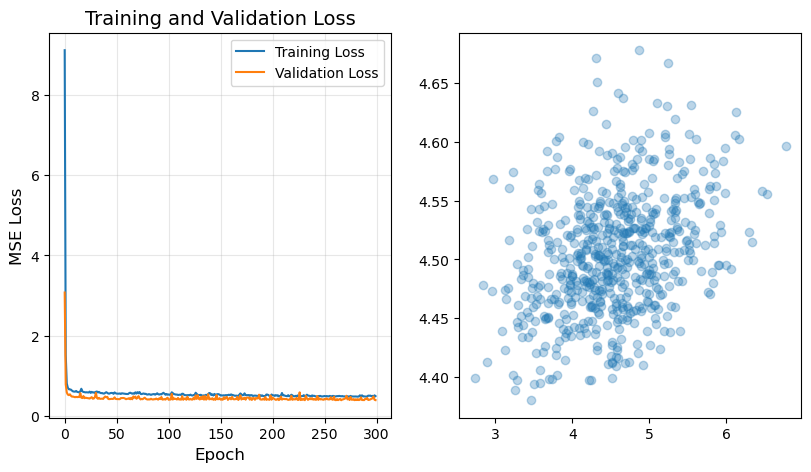

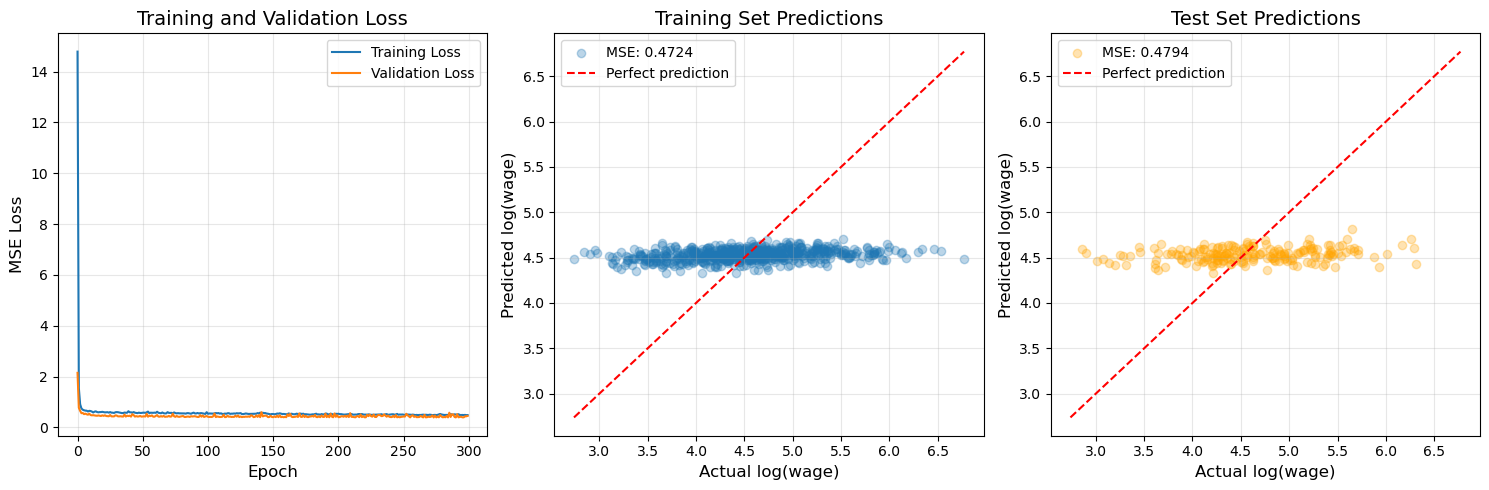

In [10]:
# Function to get predictions in batches
def get_predictions(model, X, batch_size=32):
    """
    Generates predictions for input data in batches
    Args:
        model: The trained neural network
        X: Input features
        batch_size: Number of samples per batch
    Returns:
        Concatenated predictions for all input data
    """
    dataset = TensorDataset(X)
    loader = DataLoader(dataset, batch_size=batch_size)
    predictions = []
    model.eval()
    
    with torch.no_grad():
        for (X_batch,) in loader:
            predictions.append(model(X_batch))
    
    return torch.cat(predictions)

# Generate predictions for visualization
train_preds = get_predictions(model, X_train)
test_preds = get_predictions(model, X_test)

# Create figure with three subplots
plt.figure(figsize=(15, 5))

# Subplot 1: Learning curves
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Subplot 2: Training set predictions
plt.subplot(1, 3, 2)
plt.scatter(y_train.numpy(), train_preds.numpy(), alpha=0.3, 
            label=f'MSE: {train_loss:.4f}')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Perfect prediction')
plt.xlabel('Actual log(wage)', fontsize=12)
plt.ylabel('Predicted log(wage)', fontsize=12)
plt.title('Training Set Predictions', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Subplot 3: Test set predictions
plt.subplot(1, 3, 3)
plt.scatter(y_test.numpy(), test_preds.numpy(), alpha=0.3, color='orange',
            label=f'MSE: {test_loss:.4f}')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Perfect prediction')
plt.xlabel('Actual log(wage)', fontsize=12)
plt.ylabel('Predicted log(wage)', fontsize=12)
plt.title('Test Set Predictions', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('wage_prediction_performance.png', dpi=300, bbox_inches='tight')
plt.show()